# Creating a Regression Model to Predict Wine Quality
- Group members: Claire Navara, Kelly Schultz, Rajiv Chaudhary
- Dataset: https://archive.ics.uci.edu/ml/datasets/Wine+Quality


In [337]:
#import all needed libraries
import itertools
import types
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression #For linear regression implementation
from sklearn.metrics import mean_squared_error #Its for model evaluation
from sklearn.metrics import r2_score #Its for model evaluation
%matplotlib inline

Prior to creating a model, we did some preliminary research to better understand what really goes into creating a high quality wine.  Starting with a general search, many of the factors that determine wine quality were related to weather, environment, grape type, and fermentation processes.  None of which are included in our dataset.  Our dataset focuses on the composition of wine, not necessariy how it was made.  So we looked further into the specific attributes, including...

Acids - There are two groups of acids, volatile and fixed acids.  Acids are important to the flavor of wine, impacting the sourness of the wine.  Wines with lower acid content tend to be more flat, which leads us to expect that wines with higher acidity levels may be of lesser quality.


Chlorides - When looking into the impact of chlorides on wine quality, we found that this particular ion has a large impact on the flavor.  A higher concentration of chlorides would result in a more salty flavor, thus making a lesser quality wine.  Becasue of this, we would expect higher quality wines to have a lower chloride content in general. 


Alcohol - We found that overall, as alcohol content increases, there reaches a point where those drinking the wine may experience a burning feeling, which some may not enjoy.  For a better quality wine, it seems wines with a mid-range alcohol content may be favorable. However, a winemaker may be able to offset this burning sensation, meaning they can still have a higher alcohol content.


While we only looked into a few of the attributes, we expect acidity and chlorides to have the largest impact on wine quality.  It does seem though that winemakers can balance these attributes and still create a high quality wine.

Sources-
Waterhouse Lab - https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity

Scielo - http://www.scielo.br/scielo.php?script=sci_arttext&pid=S0101-20612015000100095#:~:text=Practical%20Application:%20The%20amount%20of%20chloride%20in%20wine,salty%20taste%20and%20significantly%20decreases%20its%20market%20appeal.

https://www.telegram.com/story/lifestyle/2021/01/17/off-vine-wine-often-leaves-its-calling-card/4160713001/



In [338]:
#read and store file in dataframe
df = pd.read_csv('winequality-white.csv')

#display
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Data Exploration

In [339]:
#We looked into the info for our dataset.  It appears that there are no missing values and that each column containes 4898 
#non-null values, but we will check again for missing values later on.  We can also see that the dtypes for each of the 
#attribute columns is a float, which will be good for our regression analysis.  We will not have to perform any one-hotting
#or label-encoding to transform categorical variables.  The only possible problem with this data is that our target varibale 
#is really more categorical than continuous, which may affect our regression analysis.  It will also make any regression/scatter
#plots a little difficult to read because each instance will fall into one of the categories (1-10).

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [340]:
#Before looking into any duplicates, outliers, or missing values we can see that our data contains 4,898 rows with 12 attributes.
#One of these attributes being wine quality, which we chose to be our target variable.

print(df.shape)

(4898, 12)


In [341]:
'''
Looking into the statistical analysis of our dataset, we can again see that there are no missing values indicated.  Our
target variable, quality, indicates that there are no wines that have a quality less than 3 and there are no perfect quality wines
with a rating of ten.  All the wines, are ranked from 3-9, and based on the 50% and 75% quantiles, we assume that wines with
a qulaity ranking of 6 might be more abundant in our data given both of the quantiles are located at 6.  Becasue we expect 
chlorides to have a large impact on wine quality, we took a look at this variable as well.  All of these values are less than .5 and 
given the large difference between the 75% and the max value, we can expect to see some outliers within this attribute.  We can
also see this large difference in other attributes such as residual sugar, free sulfur dioxide, and total sulfur dioxide. So we
can expect to have to consider how to deal with outliers, whether to remove them or reassign values.  
'''

df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


### Check for Duplicates

In [342]:
'''
Here we just took a look into the rows that are duplictaed in this dataset.  This indicates that there are 937 fully duplicated
rows.  For our analysis, we will remove the duplicates becasue they will not be beneficial to our model.  Having exact duplicates
may result in the model saying that these points are more important than other points/instances, which may affect where 
the regression line is located.  Having a duplicate instance pulls the regression line towards it, which may affect the overall
regression model
'''

duplicateDFRow = df[df.duplicated()]

duplicateDFRow


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.900000,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.100000,6
7,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.800000,6
8,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.500000,6
20,6.2,0.66,0.48,1.2,0.029,29.0,75.0,0.98920,3.33,0.39,12.800000,8
...,...,...,...,...,...,...,...,...,...,...,...,...
4828,6.4,0.23,0.35,10.3,0.042,54.0,140.0,0.99670,3.23,0.47,9.200000,5
4850,7.0,0.36,0.35,2.5,0.048,67.0,161.0,0.99146,3.05,0.56,11.100000,6
4851,6.4,0.33,0.44,8.9,0.055,52.0,164.0,0.99488,3.10,0.48,9.600000,5
4856,7.1,0.23,0.39,13.7,0.058,26.0,172.0,0.99755,2.90,0.46,9.000000,6


In [343]:
#Becasue duplicate values will likely impact our regression model, we will now remove them.  We originally started with 4898
#rows, but after removing duplicates we are left with 3961 rows, so we removed the 937 dulicated rows from our data anaysis

wineDups=df
boolean = wineDups.duplicated().any()
print(boolean)

print(wineDups.shape)

wineDups.drop_duplicates(inplace=True)
print(wineDups.shape)

True
(4898, 12)
(3961, 12)


### Check for missing values

In [344]:
#We again made sure that we have no missing values, which is indicated here with having zero null values.  This means that prior
#to dealing with outliers, we have 3961 rows.
df.isnull().values.sum()

0

### Check outliers

In [345]:
'''
As you can see in the the later boxplots, our target variable has three outliers in the dataset, which are 3, 8, and 9.  When dealing 
with our outliers, we obviously do not want to remove all of the quality outliers, becasue we would be left with only 4-7.  Prior
to our data analysis, we were aware that there is a higher quantity of medium quality wines vs poor/high quality, so it is
no surprise that these are considered outiers.  In order to not take these outliers into consideration for our outlier check, 
we created a df with this column removed, so we could then check the other attributes for outliers.
'''
df_nt = df.drop(columns = ["quality"])
df_nt.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6


In [346]:
#Here we are looking into the z-scores for each of our instances
from scipy import stats
z = np.abs(stats.zscore(df_nt))
print(z)

[[0.18535197 0.10188873 0.20965146 ... 1.28992816 0.35548818 1.47039574]
 [0.6222624  0.18817926 0.04629365 ... 0.68992438 0.00309159 0.89517431]
 [1.45446025 0.0051994  0.53636707 ... 0.42594404 0.44358733 0.40212736]
 ...
 [0.39151544 0.39195672 1.17888992 ... 1.35592325 0.26738904 0.9773488 ]
 [1.54525024 0.09148993 0.28042197 ... 0.95390472 0.97218223 1.81658387]
 [0.96838284 0.6820247  0.37300927 ... 0.42594404 1.50077712 0.99483897]]


In [347]:
#for our analysis, we set the threshold to 3.  Then found the locations for each of our outliers
threshold = 3
print(np.where(z > 3))

(array([   0,   13,   18,   34,   35,   47,   63,   84,  125,  131,  142,
        151,  155,  166,  167,  168,  177,  177,  188,  193,  194,  211,
        228,  267,  275,  275,  288,  305,  316,  333,  369,  374,  403,
        425,  446,  463,  503,  541,  551,  572,  576,  576,  615,  628,
        638,  639,  640,  650,  651,  689,  697,  712,  717,  729,  733,
        734,  776,  795,  797,  817,  822,  822,  823,  823,  854,  856,
        862,  867,  871,  871,  873,  877,  888,  888,  950,  951,  977,
        982,  991,  998, 1025, 1025, 1028, 1028, 1046, 1051, 1051, 1056,
       1060, 1060, 1061, 1063, 1068, 1076, 1082, 1091, 1092, 1101, 1104,
       1109, 1123, 1159, 1159, 1162, 1174, 1175, 1185, 1199, 1200, 1201,
       1205, 1205, 1215, 1218, 1223, 1230, 1231, 1233, 1237, 1244, 1253,
       1254, 1255, 1262, 1270, 1273, 1277, 1288, 1289, 1295, 1308, 1308,
       1316, 1323, 1324, 1328, 1330, 1331, 1333, 1336, 1337, 1339, 1340,
       1342, 1347, 1347, 1348, 1356, 1379, 1382, 1

In [348]:
'''
After getting the z-scores and locations of outliers, we then added back the quality column before removing all the outliers.
This way the quality was not included in the outlier check, and we would keep the qualities of 3,8, and 9 in our data
'''
Full_df=pd.concat([df_nt,df['quality']], axis=1)
Full_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [349]:
#Here we are removing all instances that have a z-score greater than 3 so this dataset does not include the detected outliers
df_o= Full_df[(z < 3).all(axis=1)]

In [350]:
#The shape prior to our outlier detection was 3961 rows.
df.shape

(3961, 12)

In [351]:
'''
After completing our outlier analysis, we found that there are 325 outliers in our dataset.  Because our data is mostly rated
#with qualities of 4-7, we think that it may not be best to remove the outliers from our dataset.  The outliers within the
#other attributes may correspond to the outliers in our target variable.  If we remove all the outliers, this may result
#in still removing the wine outlying wine qualitites.  To comapre the difference of outliers we will create a model for both the 
full dataset and the dataset without outliers.
'''
df_o.shape

(3636, 12)

## Correlation Matrix

<AxesSubplot:>

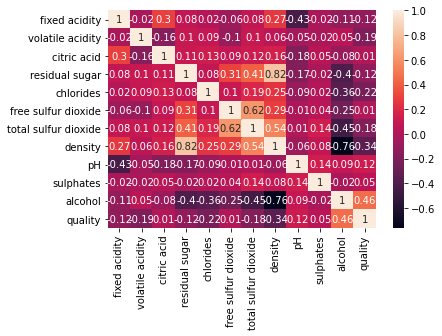

In [352]:
correlation_matrix = df.corr().round(2)
# annot = True to print the values inside the square
sb.heatmap(data=correlation_matrix, annot=True)

When looking at which attributes have the highest correlation with our target variable, the highest correlation we see is a .48 with alcohol.  The next highest correlations are density at -0.34 and chlorides at -0.22.  The correlation of quality with alcohol and chlorides was something that we expected to see given our prior research.  The negative correlation of chlorides would indicate that wines with higher chlorides have poorer wine quality, as we thought.  We can also see the positive correlation with alcohol, so as alcohol increases so does the wine quality.  We did not look much into the density, but from this correlation, we can assume that higher density wines have a poorer quality as well.  Other than these three attributes, the correlation of the others is not very high, which we also somewhat expected based on our regression plots.  Many of our regression plots were pretty rectanular with no real correlation easily seen in them.  We can also see that alcohol and density have a high correlation of -0.76, so when we conduct our analysis we will keep density out of our model due to the correlation between these attributes.  Compared to the -.76, there were not many other high correlations between attributes that we had to look out for.  

Based on this correlation matrix, three models will be created.
1. The first will look into alcohol alone to see how a model with the highest correlated value will perform.
2. The second will be of every attribute except for density due to the high correlation between density and alcohol.
3. The third will be similar to the second model, however we will also remove the outliers in this data, which we expect will have a worse result due to outliers possibly being more associated with the outlying qualities.  

## Visualizations

### Scatter Plots of the Top 3 Correlated Attributes

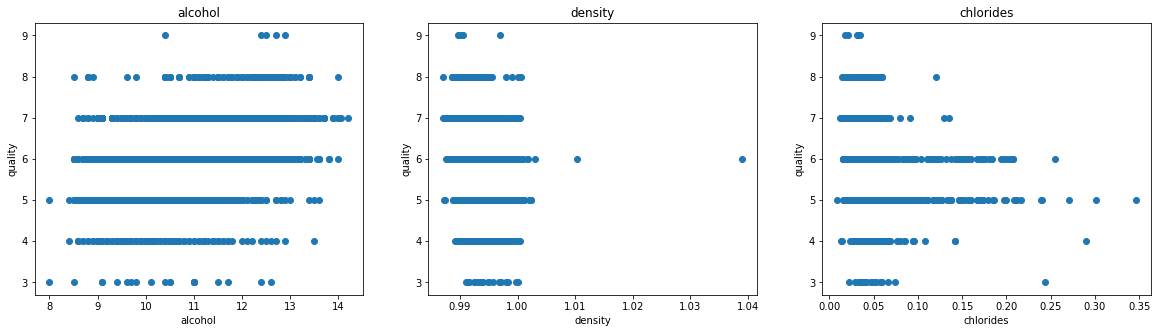

In [353]:
#The attributes with the highest correlation were alcohol, density, and chlorides. Although these had the strongest correlations
#they still aren't great. The visualizations from below do not show a distinct correlation just from looking at them.  

plt.figure(figsize=(20, 5))

features = ['alcohol', 'density', 'chlorides']
target = df['quality']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = df[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('quality')

### Boxplots

<AxesSubplot:xlabel='quality'>

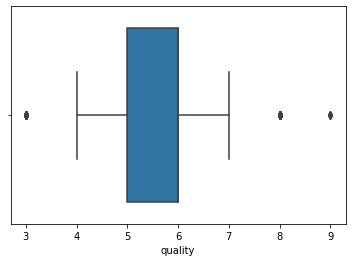

In [354]:
#The quality rating also has outliers on bothe ends, with 3, 8, and 9 being indicated as outliers. It wouldn't be beneficial
#to remove these though, because this is our target so if they were removed our model would only see the qualities rated from
#4-7.  Which means that if any sttributes are a preidctor of why those have a higher rating, removing them wouldn't help us see ths. 

sb.boxplot(x=df['quality'])

<AxesSubplot:xlabel='alcohol'>

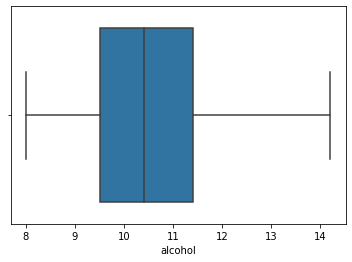

In [355]:
#We took a look into alchol, due to it being the top correlated attribute.  Based on the boxplot we can see that the alcohol
#content ranges from 8-14, and there does not appear to be any outliers within the particular attribute.  We can also see that
#75% of our instances have an alcohol content that is less than ~11.5.

sb.boxplot(x=df['alcohol'])

<AxesSubplot:xlabel='density'>

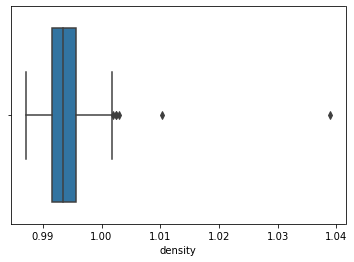

In [356]:
#We also took a look into the density, which had the second highest correlation.  We can see that there are a few outliers in 
#this attribute's values.  We can also see that 75% of the values are less than 1.  The values in this column are very small, 
#which makes it difficult to tell where some of the values on this boxplot land.

sb.boxplot(x=df['density'])

### Histogram

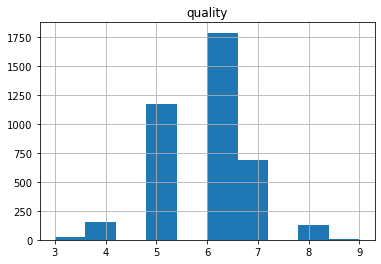

In [357]:
#This just shows the basic distribution as well. A lot in the 5 to 7 range for ratings, pretty normally 

viz = df[['quality']]
viz.hist()
plt.show()

### Regression Plots

In [358]:
'''
Using scatter plots, it was difficult to see the relationship between our attributes and target variable.  Using a regression
plot, we grouped our data by the quality rating.  From there we were able to calculate the average value for the chosen attribute
in this case, we looked into alcohol.  When we used this approach, it was much easier to see the positive correlation between
alcohol and quality.  Like our correlation plot suggested, we can expect that a higher alcohol content generally results in 
a higher quality wine.
'''

df_alc = df[['alcohol', 'quality']]
df_alc = df_alc.groupby(['quality']).mean()
df_alc.reset_index(inplace=True)

df_alc

,quality,alcohol
0,3,10.345000
1,4,10.197712
2,5,9.864182
3,6,10.646122
4,7,11.515844
5,8,11.880153
6,9,12.180000


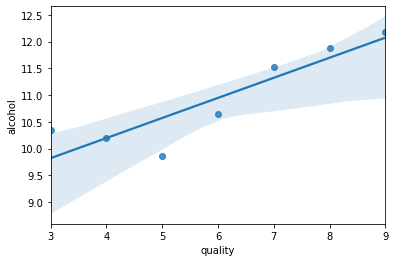

In [359]:
ax = sb.regplot(x='quality', y='alcohol', data=df_alc)

In [360]:
'''
We took a similar approach for our other two highest correlated attributes.  First we looked more into the chlorides, which 
based on our correlation matrix has a negative correlation with wine quality.  Again, taking the average value of this attribute
for each wine quality group, we were able to better see the negative correlation in this regression plot.  From this, we can
say that we would expect to see higher quality wines with lower chlorides.  This matches our original research that said more chlorides
results in a salty unpleasant flavor
'''
df_cl = df[['chlorides', 'quality']]
df_cl = df_cl.groupby(['quality']).mean()
df_cl.reset_index(inplace=True)

df_cl

,quality,chlorides
0,3,0.054300
1,4,0.050059
2,5,0.052323
3,6,0.045178
4,7,0.037556
5,8,0.036756
6,9,0.027400


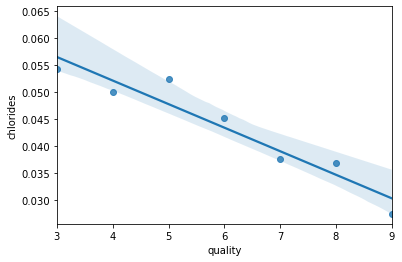

In [361]:
ax = sb.regplot(x='quality', y='chlorides', data=df_cl)

In [362]:
'''
Our last regression plot that we created, looked at the correlation between quality and density.  Similar to chlorides, our
correlation plot showed that there is a negative correlation between these two coulmns.  Taking the same approach as above, we
were again able to better see the negative correlation between density and our target variable.  Again, we could say that
we would generally expect higher quality wines to be lower in density.
'''
df_d = df[['density', 'quality']]
df_d = df_d.groupby(['quality']).mean()
df_d.reset_index(inplace=True)

df_d

,quality,density
0,3,0.994884
1,4,0.994199
2,5,0.995072
3,6,0.993722
4,7,0.992059
5,8,0.991745
6,9,0.991460


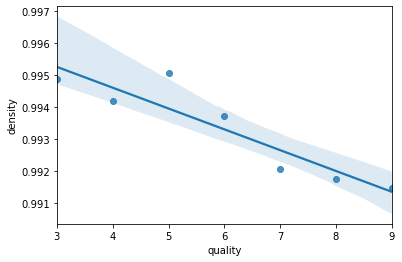

In [363]:
ax = sb.regplot(x='quality', y='density', data=df_d)

### Looking further into alcohol content

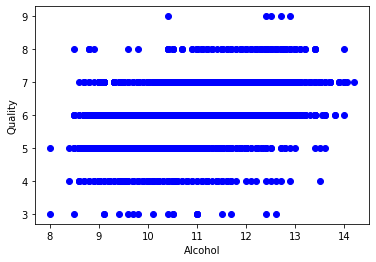

In [364]:
#Scatter plot showing the correlation between alcohol and quantity.  Not easy to determine the correlation from just looking at it

plt.scatter(df.alcohol, df.quality,  color='blue')
plt.xlabel("Alcohol")
plt.ylabel("Quality")
plt.show()

In [365]:
#This creates a testing and training set to run the data on. 

msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

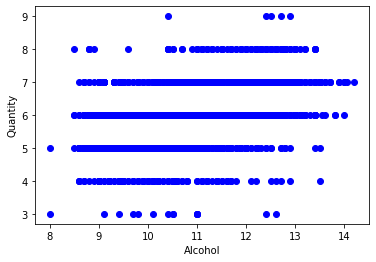

In [366]:
#this is how the training data is distributed

plt.scatter(train.alcohol, train.quality,  color='blue')
plt.xlabel("Alcohol")
plt.ylabel("Quantity")
plt.show()

In [367]:
#Modeling the data

from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['alcohol']])
train_y = np.asanyarray(train[['quality']])
regr.fit (train_x, train_y)
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[0.33453647]]
Intercept:  [2.30967735]


Text(0, 0.5, 'Quality')

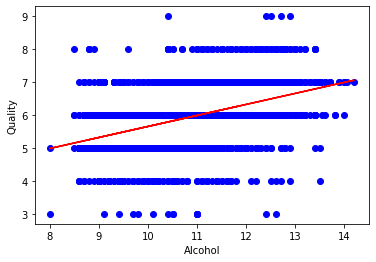

In [368]:
#This is the line of best fit over the data

plt.scatter(train.alcohol, train.quality,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.xlabel("Alcohol")
plt.ylabel("Quality")

In [369]:
'''
We thought we would run this to see if it led to any more insight on our data/any correlations. But the negative R-squared 
score tells us that the model doesn't accurately predict the data overtime and isn't helpful to us
'''
test_x = np.asanyarray(test[['alcohol']])
test_y = np.asanyarray(test[['quality']])
test_y_ = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_ - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_ - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_ , test_y) )

Mean absolute error: 0.61
Residual sum of squares (MSE): 0.60
R2-score: -2.77


## Linear Regression Models

### Highest Correlated Attribute

In [370]:
'''
In our first model, we specifically looked into the regression model focusing on the highest correlated attribute, alcohol.
For this, we isolated both the alcohol and quality columns for our analysis
'''
X = pd.DataFrame(np.c_[df['alcohol']])
Y = df['quality']

In [371]:
#After separating into our X and Y, we split them into training and test sets.  Here we used a 80/20 split where 80% of our
#data was used as the training set and 20% was used for the test set.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3168, 1)
(793, 1)
(3168,)
(793,)


In [372]:
#Here we trained the regression model
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression()

In [373]:
"""
Lets do the model evaluation
"""
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 0.7894803261273846
R2 score is 0.21082471091373756


The model performance for testing set
--------------------------------------
RMSE is 0.7893300701288524
R2 score is 0.22736353958329392


The result of this first model was not very promising.  We only got a 22% accuracy rate, which is okay for now becasue we have only tested one singular attribute.  In our next model, we will add all of the remaining attributes becasue there is not a second attribute that really sticks out over the rest.  Their correlations were all pretty similar, so we think that the best model to be created will have to take in account each of the attributes together. 

### All Attributes (except density) 

In [374]:
#For this model, we chose to include all attributes except density due to the high correlation between density and alcohol
#the remaining attributes did not show too much correlation among one another, so we felt they could all be used
X = pd.DataFrame(np.c_[df['alcohol'],df['chlorides'], df['fixed acidity'],df['volatile acidity'], df['citric acid'],df['residual sugar'], df['free sulfur dioxide'],df['total sulfur dioxide'], df['pH'],df['sulphates']], 
                 columns = ['alcohol', 'chlorides', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates'])
Y = df['quality']

In [375]:
#Here we are spliting our new X,Y in training and test sets, again using an 80/20 split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3168, 10)
(793, 10)
(3168,)
(793,)


In [376]:
#Here we train the new model

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression()

In [377]:
"""
Lets do the model evaluation
"""
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 0.7528702658763478
R2 score is 0.2823195021635584


The model performance for testing set
--------------------------------------
RMSE is 0.7400047066877374
R2 score is 0.32091073270078385


This second model was far better than the first model.  We went from a 22% success rate to a 30% success rate.  This is still not the best result and we hoped for a more successful model; however, this may be telling us that these attributes are not the best for predicting the quality of wine.  There may be a better method to predicting wine quality.  First we will also remove the outliers, but then we will conduct a classification model, which may be better suited to predict wine quality in this particualr dataset

### All Attributes (60/40 split)

In [378]:
#For this model, we chose to include all attributes except density due to the high correlation between density and alcohol
#the remaining attributes did not show too much correlation among one another, so we felt they could all be used
X = pd.DataFrame(np.c_[df['alcohol'],df['chlorides'], df['fixed acidity'],df['volatile acidity'], df['citric acid'],df['residual sugar'], df['free sulfur dioxide'],df['total sulfur dioxide'], df['pH'],df['sulphates']], 
                 columns = ['alcohol', 'chlorides', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates'])
Y = df['quality']

In [379]:
#Here we are spliting our new X,Y in training and test sets, instead using a 60/40 split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.4, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2376, 10)
(1585, 10)
(2376,)
(1585,)


In [380]:
#Here we train the new model

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression()

In [381]:
"""
Lets do the model evaluation
"""
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 0.7621965017315173
R2 score is 0.2801880727416025


The model performance for testing set
--------------------------------------
RMSE is 0.7333196637383308
R2 score is 0.30248693678606464


Just out of curiousity, we also created a model with a 60/40 training/test split to see how the model would change.  We can see here that the model performed better with an 80/20 split.  Having more data to train seemed to be beneficial for the model

### All Attributes (except density) with Outliers Removed

In [382]:
#Using the data where the outliers were removed, we isolated our attributes from our target variable
X = pd.DataFrame(np.c_[df_o['alcohol'],df_o['chlorides'], df_o['fixed acidity'],df_o['volatile acidity'], df_o['citric acid'],df_o['residual sugar'], df_o['free sulfur dioxide'],df_o['total sulfur dioxide'], df_o['pH'],df_o['sulphates']], 
                 columns = ['alcohol', 'chlorides', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates'])
Y = df_o['quality']

In [383]:
#Again splitting the data into training and test sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2908, 10)
(728, 10)
(2908,)
(728,)


In [384]:
#training model
lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

LinearRegression()

In [385]:
"""
Lets do the model evaluation
"""
y_train_predict = lin_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 0.7412986873097709
R2 score is 0.29412308089044137


The model performance for testing set
--------------------------------------
RMSE is 0.7124262663866201
R2 score is 0.28208342629726524


Like we expected, the success of this model decreased from our previous version.  The removal of outliers was not beneficial to generating our regression model.  These outliers may have affected how the model predicted the outlying qualities such as 3, 8, and 9.  I would assume that remving the outliers would leave many of the mediocre wines, in turn mis-predicting some of the outlying qualities.  For this particular dataset, it seems best to leave the outliers in the analysis.  We also felt that replacing outliers with mean/median values would change the meaning of the rows that were being impacted.  Changing the values would just result in the outlying wines having values of the mediocre wines, therefore affecting the accuracy of the model.

## Polynomial Regression Model

In [386]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [387]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [388]:
train_x = np.asanyarray(train[["quality"]])
train_y = np.asanyarray(train[["alcohol"]])

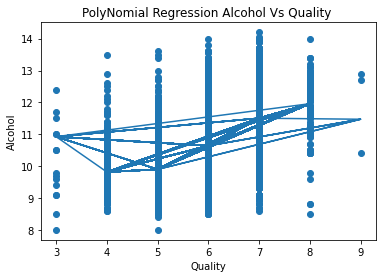

In [389]:
"""
Nonlinear regression using Polynomial regression from Scikit learn 

Wikipedia: In numerical analysis, polynomial interpolation is the interpolation of a 
given data set by the polynomial of lowest possible degree that passes through the points 
of the dataset.
"""
poly = PolynomialFeatures(degree= 3)#Degree represents the regression function for interpolation
poly_features = poly.fit_transform(train_x)
poly.fit(train_x,train_y)
poly_regression = LinearRegression()
poly_regression.fit(poly_features,train_y)

#ploting the data  
plt.scatter(train_x,train_y)
plt.plot(train_x,poly_regression.predict(poly_features))
plt.title("PolyNomial Regression Alcohol Vs Quality ")
plt.xlabel("Quality")
plt.ylabel("Alcohol")
plt.show()

In [390]:
"""
Polynomial model evaluation
"""
from sklearn.metrics import r2_score #Its for model evaluation
y_train_predict = poly_regression.predict(poly_features)
rmse = (np.sqrt(mean_squared_error(train_y, y_train_predict)))
r2 = r2_score(train_y, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('R2 score is {}'.format(r2))
print("\n")

The model performance for training set
--------------------------------------
R2 score is 0.25180232545196735




Just to ensure that our data was not a polynomial regression problem, we also ran polynomial regression using alcohol as the attribute.  This model had a 25% success rate, which is much lower than our multiple linear regression models.  This just helps us demonstrate that this dataset is not better suited to be a polynomial regression, just like we expected based on our visualizations and correlations

# Classification Model

## 7 Class Labels (3-9)

In [391]:
'''
The first classification model that we decided to run, uses the class labels of 3-9, which gives us 7 possible labels.
From the start, we knew that our data was not necessarily meant for a regression problem, so we wanted to try a classification
model instead nd hope for a better result.  We are still using the dataset that we used for our regression model
'''
X = df.iloc[:, :-1].values
X

array([[ 7.  ,  0.27,  0.36, ...,  3.  ,  0.45,  8.8 ],
       [ 6.3 ,  0.3 ,  0.34, ...,  3.3 ,  0.49,  9.5 ],
       [ 8.1 ,  0.28,  0.4 , ...,  3.26,  0.44, 10.1 ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  2.99,  0.46,  9.4 ],
       [ 5.5 ,  0.29,  0.3 , ...,  3.34,  0.38, 12.8 ],
       [ 6.  ,  0.21,  0.38, ...,  3.26,  0.32, 11.8 ]])

In [392]:
#lets get the class label/target attribute out of DataFrame, in this case it is quality
y = df.iloc[:, -1].values
y

array([6, 6, 6, ..., 6, 7, 6], dtype=int64)

In [393]:
#Sampling - Splitting the training and test sets.  Here we have an 80/20 split for training/test sets.  These sets will be
#used to create a tree based and KNN classifiers
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3168, 11) (3168,)
Test set: (793, 11) (793,)


### Tree Based Classifier

In [394]:
y_train

array([5, 6, 6, ..., 6, 4, 5], dtype=int64)

In [395]:
X_train

array([[ 6.7  ,  0.265,  0.22 , ...,  3.25 ,  0.41 , 10.2  ],
       [ 7.1  ,  0.31 ,  0.38 , ...,  3.14 ,  0.44 ,  9.9  ],
       [ 6.8  ,  0.22 ,  0.29 , ...,  3.3  ,  0.44 , 10.3  ],
       ...,
       [ 7.5  ,  0.18 ,  0.37 , ...,  3.2  ,  0.55 , 10.5  ],
       [ 5.8  ,  0.28 ,  0.35 , ...,  3.28 ,  0.5  , 10.2  ],
       [ 7.8  ,  0.13 ,  0.3  , ...,  3.43 ,  0.41 ,  9.   ]])

In [396]:
#Here we actually train the model
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [397]:
#This shows us what the predicted quality is for each instance in our test set
y_predict=clf.predict(X_test)
y_predict

array([5, 6, 6, 6, 4, 5, 6, 7, 6, 6, 7, 6, 6, 6, 6, 7, 7, 6, 6, 6, 6, 6,
       6, 7, 6, 7, 6, 6, 5, 7, 5, 5, 6, 6, 6, 6, 6, 5, 5, 7, 6, 5, 5, 7,
       8, 5, 6, 5, 5, 5, 6, 3, 6, 5, 6, 5, 6, 6, 6, 7, 6, 5, 4, 5, 6, 6,
       5, 8, 6, 5, 5, 5, 6, 7, 5, 6, 6, 5, 6, 6, 5, 6, 5, 8, 5, 5, 7, 6,
       6, 6, 4, 6, 7, 6, 7, 8, 6, 7, 7, 6, 6, 5, 7, 6, 6, 6, 6, 6, 6, 6,
       8, 7, 6, 7, 5, 4, 6, 5, 6, 5, 5, 7, 6, 6, 6, 6, 5, 5, 5, 6, 5, 6,
       7, 8, 7, 6, 8, 5, 5, 6, 7, 6, 6, 5, 6, 7, 6, 5, 5, 5, 6, 8, 8, 6,
       7, 6, 6, 5, 6, 6, 8, 6, 6, 6, 5, 6, 6, 6, 5, 5, 6, 4, 6, 6, 6, 5,
       6, 6, 7, 5, 5, 5, 6, 6, 6, 4, 6, 7, 5, 6, 7, 6, 6, 6, 6, 5, 5, 3,
       6, 7, 6, 7, 7, 6, 6, 5, 5, 6, 7, 6, 5, 6, 5, 6, 6, 6, 6, 7, 6, 4,
       6, 5, 7, 6, 4, 6, 6, 5, 5, 5, 5, 6, 7, 6, 5, 6, 6, 6, 6, 7, 6, 6,
       5, 7, 5, 5, 5, 7, 5, 3, 6, 6, 7, 7, 6, 6, 7, 4, 6, 6, 5, 5, 4, 4,
       5, 6, 6, 5, 7, 6, 6, 5, 6, 5, 7, 5, 8, 7, 4, 6, 6, 5, 7, 4, 5, 5,
       6, 5, 5, 6, 6, 6, 6, 5, 5, 6, 6, 7, 6, 7, 6,

In [398]:
#Accuracy evaluation
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_predict))

Train set Accuracy:  1.0
Test set Accuracy:  0.46027742749054223


In [399]:
#Confusion matrix is another handy evaluation of model

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_predict)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[  0   2   1   2   1   0]
 [  0   7   9   8   0   0]
 [  2  11 103  84  19   5]
 [  2  10  91 192  61  16]
 [  0   2  13  65  62   8]
 [  0   0   2   6   8   1]]


In [400]:
"""
Confusion matrix:
            Actual 3.  Actual 4      Actual 5    Actual 6    Actual 7    Actual 8
Predicted 3 [   0         2             0           3           1           0      ]
Predicted 4 [   0         6             10          7           0           1      ]
Predicted 5 [   2         13            99          84          22          4      ]
Predicted 6 [   1         11            89         192          65          14     ]
Predicted 7 [   0         2             13          60          63          12     ]
Predicted 8 [   0         0             2           6           9           0      ]


Based on this confusion matrix, we can see that the majority of our instances in the dataset were a quality of 6.  The largest
number in the matrix is 192, which indicates that wine quality 6 was predicted accurately 192 times.  As for qualities 5 and 7, 
We can see that these were also predicted correctly a fair amount.  Based on what we know of our data, we expected the middle
qualities to be predicted correctly more often becasue they are higher in number of instances.  For the qualities that were
shown as outliers previously (3 and 8), we see that they had a small representation in the dataset, and this model was unable 
to accurately predict either of these wine qualities.  

"""

'\nConfusion matrix:\n            Actual 3.  Actual 4      Actual 5    Actual 6    Actual 7    Actual 8\nPredicted 3 [   0         2             0           3           1           0      ]\nPredicted 4 [   0         6             10          7           0           1      ]\nPredicted 5 [   2         13            99          84          22          4      ]\nPredicted 6 [   1         11            89         192          65          14     ]\nPredicted 7 [   0         2             13          60          63          12     ]\nPredicted 8 [   0         0             2           6           9           0      ]\n\n\nBased on this confusion matrix, we can see that the majority of our instances in the dataset were a quality of 6.  The largest\nnumber in the matrix is 192, which indicates that wine quality 6 was predicted accurately 192 times.  As for qualities 5 and 7, \nWe can see that these were also predicted correctly a fair amount.  Based on what we know of our data, we expected th

### KNN

In [404]:
#(K-NN) based classifier

from sklearn.neighbors import KNeighborsClassifier
k = 4

#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=4)

In [405]:
#Predicting
yhat = neigh.predict(X_test)
yhat[0:5]

array([6, 6, 6, 7, 6], dtype=int64)

In [406]:
#Accuracy evaluation
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.6306818181818182
Test set Accuracy:  0.40226986128625475


In [407]:
#Confusion matrix is another handy evaluation of model
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,yhat)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[  0   0   2   3   1   0]
 [  0   1  12  10   1   0]
 [  0   8 103  98  14   1]
 [  0   5 132 190  43   2]
 [  0   0  35  88  25   2]
 [  0   1   3   9   4   0]]


In [408]:
"""
Confusion matrix:
            Actual 3.  Actual 4      Actual 5    Actual 6    Actual 7    Actual 8
Predicted 3 [   0         0             2           3           1           0      ]
Predicted 4 [   0         1             12          10          1           0      ]
Predicted 5 [   0         8            103          98          14          1      ]
Predicted 6 [   0         5            132          190         43          2      ]
Predicted 7 [   0         0             35          88          25          2      ]
Predicted 8 [   0         1             3           9           4           0      ]


The largest number in the matrix is 190, which indicates that wine quality 6 was predicted accurately 190 times.  This is good,
however it was also mis-predicted as a quality of 5 132 times.  The amount of times it was correctly predicted is almost
equal to the times an instance was mislaeled.  Again we can see that the qualities of 3 and 8 were never correctly identified
in this model.  
"""

'\nConfusion matrix:\n            Actual 3.  Actual 4      Actual 5    Actual 6    Actual 7    Actual 8\nPredicted 3 [   0         0             2           3           1           0      ]\nPredicted 4 [   0         1             12          10          1           0      ]\nPredicted 5 [   0         8            103          98          14          1      ]\nPredicted 6 [   0         5            132          190         43          2      ]\nPredicted 7 [   0         0             35          88          25          2      ]\nPredicted 8 [   0         1             3           9           4           0      ]\n\n\nThe largest number in the matrix is 190, which indicates that wine quality 6 was predicted accurately 190 times.  This is good,\nhowever it was also mis-predicted as a quality of 5 132 times.  The amount of times it was correctly predicted is almost\nequal to the times an instance was mislaeled.  Again we can see that the qualities of 3 and 8 were never correctly identifie

## Divided into Binary

In [409]:
#Another approach was to try a binary classification model in the hope for better accuracy. The plan is to divide wine
#quality into two parts- medium and high.
uniquevalues= df.quality.unique()

In [410]:
uniquevalues

array([6, 5, 7, 8, 4, 3, 9], dtype=int64)

In [411]:
#In order to do a binary classification, we split our wine qualities into two groups.  Those that were originally labeled as
#3-6 would now be labeled as medium quality.  This leaves qualities 7-9 as high quality wines.  This way we will be able
#to label encode our target variable and perform a binary classification model
df.loc[df.quality == 3, "quality"] = "medium"
df.loc[df.quality == 4, "quality"] = "medium"
df.loc[df.quality == 5, "quality"] = "medium"
df.loc[df.quality == 6, "quality"] = "medium"
df.loc[df.quality == 7, "quality"] = "high"
df.loc[df.quality == 8, "quality"] = "high"
df.loc[df.quality == 9, "quality"] = "high"

df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,medium
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,medium
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,medium
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,medium
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6,medium
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,medium
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,medium
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,medium
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,high


<AxesSubplot:>

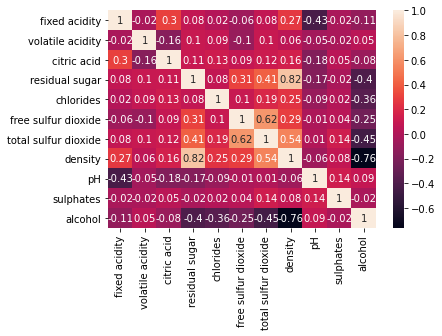

In [412]:
correlation_matrix = df.corr().round(2)
# annot = True to print the values inside the square
sb.heatmap(data=correlation_matrix, annot=True)

In [413]:
#getting all the oredictor attributes except quality in our predictors dataframe X
X = df.iloc[:, :-1].values
X

array([[ 7.  ,  0.27,  0.36, ...,  3.  ,  0.45,  8.8 ],
       [ 6.3 ,  0.3 ,  0.34, ...,  3.3 ,  0.49,  9.5 ],
       [ 8.1 ,  0.28,  0.4 , ...,  3.26,  0.44, 10.1 ],
       ...,
       [ 6.5 ,  0.24,  0.19, ...,  2.99,  0.46,  9.4 ],
       [ 5.5 ,  0.29,  0.3 , ...,  3.34,  0.38, 12.8 ],
       [ 6.  ,  0.21,  0.38, ...,  3.26,  0.32, 11.8 ]])

In [414]:
#getting the class label attributes into a single dataframe
y = df.iloc[:, -1].values
y

array(['medium', 'medium', 'medium', ..., 'medium', 'high', 'medium'],
      dtype=object)

In [415]:
#Converting our class label into binary value of 0 and 1

from sklearn.preprocessing import LabelEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
print(y)

[1 1 1 ... 1 0 1]


In [416]:
y.shape

(3961,)

In [417]:
#Sampling - Train Test Split 
#The data is split into 80 percent training set and 20 percent test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3168, 11) (3168,)
Test set: (793, 11) (793,)


In [418]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [419]:
X_train

array([[ 6.7  ,  0.265,  0.22 , ...,  3.25 ,  0.41 , 10.2  ],
       [ 7.1  ,  0.31 ,  0.38 , ...,  3.14 ,  0.44 ,  9.9  ],
       [ 6.8  ,  0.22 ,  0.29 , ...,  3.3  ,  0.44 , 10.3  ],
       ...,
       [ 7.5  ,  0.18 ,  0.37 , ...,  3.2  ,  0.55 , 10.5  ],
       [ 5.8  ,  0.28 ,  0.35 , ...,  3.28 ,  0.5  , 10.2  ],
       [ 7.8  ,  0.13 ,  0.3  , ...,  3.43 ,  0.41 ,  9.   ]])

### Tree Based Classifier

In [420]:
#using tree based classifier for model building
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [421]:
#prediction
y_predict=clf.predict(X_test)
y_predict

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,

In [422]:
#Accuracy evaluation

from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, clf.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_predict))

Train set Accuracy:  1.0
Test set Accuracy:  0.7604035308953342


In [423]:
#Confusion matrix is another handy evaluation of model

from sklearn.metrics import confusion_matrix
labels=[0, 1]
cm=confusion_matrix(y_test,y_predict,labels)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[ 73  94]
 [ 96 530]]


C:\Users\USER\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [424]:
"""
Confusion matrix:
            Actual 0.  Actual 1
Predicted 0 [65        102]
Predicted 1 [ 99       527]

Accuracy= [Predicted 0 and Actual 0] # + [Predicted 1 and Actual 1] # / Total population
        = (65+527)/793
Error= [Predicted 1 but Actual 0] # + [Predicted 0 and Actual 1] # / Total popullation
     = (99+102)/793
Precision= [Predicted 0 and Actual 0]/[Predicted 0 and Actual 0]+[Predicted 0 and Actual 1]
         = 65/(65+102)
Recall= [Predicted 0 and Actual 0]/[Predicted 0 and Actual 0]+[Predicted 1 and Actual 0]
      = 65/(65+99)
Type I error= [Predicted 0 and Actual 1]= 102
Type II error= [Predicted 1 and Actual 0]= 99
"""

'\nConfusion matrix:\n            Actual 0.  Actual 1\nPredicted 0 [65        102]\nPredicted 1 [ 99       527]\n\nAccuracy= [Predicted 0 and Actual 0] # + [Predicted 1 and Actual 1] # / Total population\n        = (65+527)/793\nError= [Predicted 1 but Actual 0] # + [Predicted 0 and Actual 1] # / Total popullation\n     = (99+102)/793\nPrecision= [Predicted 0 and Actual 0]/[Predicted 0 and Actual 0]+[Predicted 0 and Actual 1]\n         = 65/(65+102)\nRecall= [Predicted 0 and Actual 0]/[Predicted 0 and Actual 0]+[Predicted 1 and Actual 0]\n      = 65/(65+99)\nType I error= [Predicted 0 and Actual 1]= 102\nType II error= [Predicted 1 and Actual 0]= 99\n'

### KNN Classifier

In [425]:
#(K-NN) based classifier

from sklearn.neighbors import KNeighborsClassifier
k = 3

#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(n_neighbors=3)

In [426]:
#Predicting
yhat = neigh.predict(X_test)
yhat[0:5]

array([1, 1, 1, 0, 1])

In [427]:
#Accuracy evaluation
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8667929292929293
Test set Accuracy:  0.7465321563682219


In [428]:
#Confusion matrix is another handy evaluation of model
from sklearn.metrics import confusion_matrix
labels=[0,1]
cm=confusion_matrix(y_test,yhat,labels)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[ 42 125]
 [ 76 550]]


C:\Users\USER\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [429]:
"""
Confusion matrix:
            Actual 0.  Actual 1
Predicted 0 [42       125]
Predicted 1 [ 76       550]

Accuracy= [Predicted 0 and Actual 0] # + [Predicted 1 and Actual 1] # / Total population
        = (42+550)/793
Error= [Predicted 1 but Actual 0] # + [Predicted 0 and Actual 1] # / Total popullation
     = (76+125)/793
Precision= [Predicted 0 and Actual 0]/[Predicted 0 and Actual 0]+[Predicted 0 and Actual 1]
         = 42/(42+125)
Recall= [Predicted 0 and Actual 0]/[Predicted 0 and Actual 0]+[Predicted 1 and Actual 0]
      = 42/(42+76)
Type I error= [Predicted 0 and Actual 1]= 125
Type II error= [Predicted 1 and Actual 0]= 42
"""

'\nConfusion matrix:\n            Actual 0.  Actual 1\nPredicted 0 [42       125]\nPredicted 1 [ 76       550]\n\nAccuracy= [Predicted 0 and Actual 0] # + [Predicted 1 and Actual 1] # / Total population\n        = (42+550)/793\nError= [Predicted 1 but Actual 0] # + [Predicted 0 and Actual 1] # / Total popullation\n     = (76+125)/793\nPrecision= [Predicted 0 and Actual 0]/[Predicted 0 and Actual 0]+[Predicted 0 and Actual 1]\n         = 42/(42+125)\nRecall= [Predicted 0 and Actual 0]/[Predicted 0 and Actual 0]+[Predicted 1 and Actual 0]\n      = 42/(42+76)\nType I error= [Predicted 0 and Actual 1]= 125\nType II error= [Predicted 1 and Actual 0]= 42\n'

### Conducting a chi-square test 

In [430]:
chiSquareDF= df
chiSquareDF

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,medium
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,medium
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,medium
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,medium
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6,medium
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,medium
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,medium
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,medium
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,high


In [431]:
#Here, using the chi-square method, we are comparing each attribute of a specific column to the attribute of the quality column

from sklearn.feature_selection import chi2

chi_test = chi2(chiSquareDF.iloc[:, :11], chiSquareDF['quality'])
features = pd.DataFrame({
    'features': chiSquareDF.columns[:11],
    'chi2': chi_test[0],
    'p-value': chi_test[1]
})

In [432]:
#displaying the values of our chi-square test
features

,features,chi2,p-value
0,fixed acidity,3.354270,6.703094e-02
1,volatile acidity,0.497584,4.805636e-01
2,citric acid,0.090848,7.631017e-01
3,residual sugar,301.787154,1.344047e-67
4,chlorides,1.654681,1.983231e-01
5,free sulfur dioxide,17.254763,3.268771e-05
6,total sulfur dioxide,1750.261402,0.000000e+00
7,density,0.003336,9.539397e-01
8,pH,0.389080,5.327833e-01
9,sulphates,0.195378,6.584781e-01



From the chi-square test, we see that there is a the strongest relationship between the quality
of the wine is with residual sugar, free suphur dioxode, total sulphur dioxide and alcohol as the p-value is very small.

Also, a general inference can be made that since Sulphur Dioxide is a preservative and has anti bacterial quality, it prevents the wine from going bad. Residual Sugar in the wine is from natural grape sugars leftover in a wine after the alcoholic fermentation finishes and affects the sweetness of the wine. Finally, wine with strong alcoholic content also showed better wine quality. 

# Overall Conclusions

Overall, our first conclusion is that this dataset was better suited for a classification model.  Both classification models that we created (multi-label and binary label) resulted in a higher success rate when it came to labeling/predicting white wine quality.  Our best model was the binary classification which resulted in an accuracy rate of 74%.  While this still is not the best for accuracy, it is far better than any of our regression models, which maxed a 34% success rate when predicting quality.

From the start, we had a feeling that our results were not going to give us what we hoped for.  In our beginning research, we really had to be specific to our attributes when looking for their impact on wine quality.  In general searches for "what factors impact wine quality?", the majority of the results would indicate factors such as location, temperature, fermentation process, etc.  None of these factors were specific to our attributes.  Because of this, we think that a dataset that was more focused on temperature, location, and other factors may result in a better performing model.

We also have to keep in mind that the wine quality label is given by wine tasting experts.  There is not really a scientific meaning behind this rating, rather an opinion of the one drinking it.  While these experts may rank wine quality similar to one another, this may impact which attribute values are associted with which qualities.   